## Timeseries with spark-ts

In [2]:
from datetime import datetime

from pyspark import SparkContext, SQLContext
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType, StringType

from sparkts.datetimeindex import uniform, BusinessDayFrequency
from sparkts.timeseriesrdd import time_series_rdd_from_observations

def lineToRow(line):
    (year, month, day, symbol, volume, price) = line.split("\t")
    # Python 2.x compatible timestamp generation
    dt = datetime(int(year), int(month), int(day))
    return (dt, symbol, float(price))

def loadObservations(sparkContext, sqlContext, path):
    textFile = sparkContext.textFile(path)
    rowRdd = textFile.map(lineToRow)
    schema = StructType([
        StructField('timestamp', TimestampType(), nullable=True),
        StructField('symbol', StringType(), nullable=True),
        StructField('price', DoubleType(), nullable=True),
    ])
    return sqlContext.createDataFrame(rowRdd, schema);

In [3]:
!wget https://raw.githubusercontent.com/sryza/spark-ts-examples/master/data/ticker.tsv

--2016-10-12 15:28:24--  https://raw.githubusercontent.com/sryza/spark-ts-examples/master/data/ticker.tsv
Resolving raw.githubusercontent.com... 151.101.12.133
Connecting to raw.githubusercontent.com|151.101.12.133|:443... ^C


In [4]:
tickerObs = loadObservations(sc, sqlContext, "ticker.tsv")

In [82]:
tickerObs.show(2, truncate=False)

+---------------------+------+------+
|timestamp            |symbol|price |
+---------------------+------+------+
|2015-08-14 00:00:00.0|ADP   |82.99 |
|2015-09-14 00:00:00.0|NKE   |111.78|
+---------------------+------+------+
only showing top 2 rows



In [92]:
# Create an daily DateTimeIndex over August and September 2015
freq = BusinessDayFrequency(1, 1, sc)
dtIndex = uniform(start='2015-08-03T00:00+01:00', end='2015-09-22T00:00+01:00', freq=freq, sc=sc)

In [93]:
dtIndex

uniform,Europe/London,2015-08-03T00:00+01:00[Europe/London],37,businessDays 1 firstDayOfWeek 1

In [94]:
tickerTsrdd = time_series_rdd_from_observations(dtIndex, tickerObs, "timestamp", "symbol", "price")

In [95]:
tickerTsrdd.take(20)

[(u'AAL',
  array([ 41.71,  42.74,  42.96,  42.18,  41.49,  41.68,  42.7 ,  42.52,
          42.67,  42.88,  43.95,  43.63,  43.53,  41.98,  39.75,  37.62,
          37.5 ,  38.85,  39.03,  38.62,  38.98,  39.2 ,  41.51,  40.89,
          40.6 ,    nan,  40.8 ,  41.  ,  41.21,  42.15,  42.29,  42.64,
          43.06,  43.99,  43.49,  43.24,  41.19])),
 (u'AAPL',
  array([ 118.44  ,  114.64  ,  115.4   ,  115.13  ,  115.52  ,  119.6901,
          113.5499,  115.24  ,  115.15  ,  116.    ,  117.1601,  116.5   ,
          115.01  ,  112.65  ,  105.76  ,  103.155 ,  103.74  ,  109.625 ,
          112.92  ,  113.29  ,  112.76  ,  107.72  ,  112.34  ,  110.37  ,
          109.27  ,       nan,  112.21  ,  110.15  ,  112.57  ,  114.017 ,
          115.3   ,  116.28  ,  116.35  ,  113.92  ,  113.45  ,  115.23  ,
          113.432 ])),
 (u'ADI',
  array([ 58.67,  58.48,  60.7 ,  58.87,  59.61,  61.09,  59.38,  59.74,
          59.  ,  58.84,  59.5 ,  57.9 ,  58.38,  53.82,  53.78,  51.67,
      

In [96]:
tickerTsrdd.cache()

# Count the number of series (number of symbols)
print(tickerTsrdd.count())

# Impute missing values using linear interpolation
filled = tickerTsrdd.fill("linear")

# Compute return rates
returnRates = filled.return_rates()

# Durbin-Watson test for serial correlation, ported from TimeSeriesStatisticalTests.scala
def dwtest(residuals):
    residsSum = residuals[0] * residuals[0]
    diffsSum = 0.0
    i = 1
    while i < len(residuals):
        residsSum += residuals[i] * residuals[i]
        diff = residuals[i] - residuals[i - 1]
        diffsSum += diff * diff
        i += 1
    return diffsSum / residsSum

# Compute Durbin-Watson stats for each series
# Swap ticker symbol and stats so min and max compare the statistic value, not the
# ticker names.
dwStats = returnRates.map_series(lambda row: (row[0], [dwtest(row[1])])).map(lambda x: (x[1], x[0]))

print(dwStats.min())
print(dwStats.max())

104
([0.99930539174187916], u'NFLX')
([2.3701164736953166], u'DISCK')


In [97]:
returnRates.take(2)

[(u'AAL',
  array([ 0.02469432,  0.0051474 , -0.01815642, -0.01635846,  0.00457942,
          0.02447217, -0.00421546,  0.00352775,  0.00492149,  0.02495336,
         -0.007281  , -0.002292  , -0.03560763, -0.05312053, -0.05358491,
         -0.00318979,  0.036     ,  0.0046332 , -0.01050474,  0.0093216 ,
          0.00564392,  0.05892857, -0.01493616, -0.0070922 ,  0.00246305,
          0.002457  ,  0.00490196,  0.00512195,  0.02281   ,  0.00332147,
          0.00827619,  0.00984991,  0.02159777, -0.01136622, -0.00574845,
         -0.04740981])),
 (u'AAPL',
  array([-0.03208376,  0.00662945, -0.00233969,  0.00338748,  0.03609851,
         -0.05130082,  0.01488421, -0.00078098,  0.00738168,  0.01000086,
         -0.00563417, -0.0127897 , -0.02051995, -0.06116289, -0.02463124,
          0.00567108,  0.05672836,  0.03005701,  0.00327666, -0.00467826,
         -0.0446967 ,  0.04288897, -0.01753605, -0.00996648,  0.01345291,
          0.01327434, -0.01835844,  0.02197004,  0.01285422,  0.01

In [98]:
tickerTsrdd.take(2)

[(u'AAL',
  array([ 41.71,  42.74,  42.96,  42.18,  41.49,  41.68,  42.7 ,  42.52,
          42.67,  42.88,  43.95,  43.63,  43.53,  41.98,  39.75,  37.62,
          37.5 ,  38.85,  39.03,  38.62,  38.98,  39.2 ,  41.51,  40.89,
          40.6 ,    nan,  40.8 ,  41.  ,  41.21,  42.15,  42.29,  42.64,
          43.06,  43.99,  43.49,  43.24,  41.19])),
 (u'AAPL',
  array([ 118.44  ,  114.64  ,  115.4   ,  115.13  ,  115.52  ,  119.6901,
          113.5499,  115.24  ,  115.15  ,  116.    ,  117.1601,  116.5   ,
          115.01  ,  112.65  ,  105.76  ,  103.155 ,  103.74  ,  109.625 ,
          112.92  ,  113.29  ,  112.76  ,  107.72  ,  112.34  ,  110.37  ,
          109.27  ,       nan,  112.21  ,  110.15  ,  112.57  ,  114.017 ,
          115.3   ,  116.28  ,  116.35  ,  113.92  ,  113.45  ,  115.23  ,
          113.432 ]))]

In [99]:
from sparkts.models import ARIMA

for ts in 
model = returnRates.map_series(lambda row: (row[0], [dwtest(row[1])])).map(lambda x: (x[1], x[0]))
arimaModel = ARIMA.fitModel(1, 0, 1, ts)

In [102]:
arimaModel = ARIMA.fit_model(1, 0, 1, tickerTsrdd)

In [129]:
returnRates.collect()[0][1]

array([ 0.02469432,  0.0051474 , -0.01815642, -0.01635846,  0.00457942,
        0.02447217, -0.00421546,  0.00352775,  0.00492149,  0.02495336,
       -0.007281  , -0.002292  , -0.03560763, -0.05312053, -0.05358491,
       -0.00318979,  0.036     ,  0.0046332 , -0.01050474,  0.0093216 ,
        0.00564392,  0.05892857, -0.01493616, -0.0070922 ,  0.00246305,
        0.002457  ,  0.00490196,  0.00512195,  0.02281   ,  0.00332147,
        0.00827619,  0.00984991,  0.02159777, -0.01136622, -0.00574845,
       -0.04740981])

In [130]:
from pyspark.mllib.linalg import Vectors

In [131]:
ts = Vectors.dense(returnRates.collect()[0][1])

In [135]:
m = ARIMA.fit_model(1,0,1,ts, sc=sc) 

In [136]:
m.coefficients

[-0.0012474547399206936, 0.2666755318221923, 0.0961795619837402]

In [137]:
forecast = m.forecast(ts, 20)

In [140]:
%matplotlib inline

In [142]:
import matplotlib.pyplot as plt

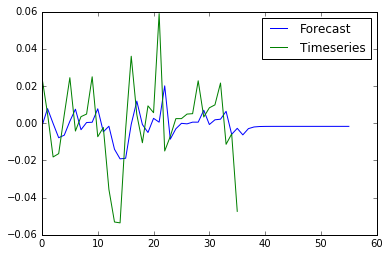

In [157]:
plt.plot(forecast.toArray(), label="Forecast")
plt.plot(ts.toArray(), label="Timeseries")
plt.legend(loc="best")



In [152]:
dwStats.collect()

[(u'AAL',
  DenseVector([0.0247, 0.0051, -0.0182, -0.0164, 0.0046, 0.0245, -0.0042, 0.0035, 0.0049, 0.025, -0.0073, -0.0023, -0.0356, -0.0531, -0.0536, -0.0032, 0.036, 0.0046, -0.0105, 0.0093, 0.0056, 0.0589, -0.0149, -0.0071, 0.0025, 0.0025, 0.0049, 0.0051, 0.0228, 0.0033, 0.0083, 0.0098, 0.0216, -0.0114, -0.0057, -0.0474])),
 (u'AAPL',
  DenseVector([-0.0321, 0.0066, -0.0023, 0.0034, 0.0361, -0.0513, 0.0149, -0.0008, 0.0074, 0.01, -0.0056, -0.0128, -0.0205, -0.0612, -0.0246, 0.0057, 0.0567, 0.0301, 0.0033, -0.0047, -0.0447, 0.0429, -0.0175, -0.01, 0.0135, 0.0133, -0.0184, 0.022, 0.0129, 0.0113, 0.0085, 0.0006, -0.0209, -0.0041, 0.0157, -0.0156])),
 (u'ADI',
  DenseVector([-0.0032, 0.038, -0.0301, 0.0126, 0.0248, -0.028, 0.0061, -0.0124, -0.0027, 0.0112, -0.0269, 0.0083, -0.0781, -0.0007, -0.0392, -0.0205, 0.0713, 0.0417, -0.0005, -0.0105, -0.0414, 0.0194, 0.0106, -0.0219, 0.0353, 0.0341, -0.026, -0.0046, 0.0061, 0.0215, 0.0129, 0.0026, -0.0089, -0.0218, -0.0009, -0.0254])),
 (u'AEP',

In [163]:
import numpy as np
import statsmodels.tsa.stattools as ts



In [180]:
dwStats.take(1)

[(u'AAL',
  array([ 0.02469432,  0.0051474 , -0.01815642, -0.01635846,  0.00457942,
          0.02447217, -0.00421546,  0.00352775,  0.00492149,  0.02495336,
         -0.007281  , -0.002292  , -0.03560763, -0.05312053, -0.05358491,
         -0.00318979,  0.036     ,  0.0046332 , -0.01050474,  0.0093216 ,
          0.00564392,  0.05892857, -0.01493616, -0.0070922 ,  0.00246305,
          0.002457  ,  0.00490196,  0.00512195,  0.02281   ,  0.00332147,
          0.00827619,  0.00984991,  0.02159777, -0.01136622, -0.00574845,
         -0.04740981]))]

## Augmented Dickey Fueller test

In [183]:
returnRates.map(lambda x: (x[0], ts.adfuller(x[1],1))).take(2)

[(u'AAL',
  (-3.8435486776337977,
   0.0024918958688509344,
   0,
   35,
   {'1%': -3.6327426647230316,
    '10%': -2.6130173469387756,
    '5%': -2.9485102040816327},
   -159.89607317623569)),
 (u'AAPL',
  (-5.9263894376379227,
   2.4380488197144194e-07,
   0,
   35,
   {'1%': -3.6327426647230316,
    '10%': -2.6130173469387756,
    '5%': -2.9485102040816327},
   -152.06956251179929))]

## Durbin Watson

In [186]:
import statsmodels.api as sm
returnRates.map(lambda x: (x[0], sm.stats.durbin_watson(x[1]))).take(2)

[(u'AAL', 1.2651505598339603), (u'AAPL', 1.9645069225856866)]

## ARMA Model

In [200]:
arma_20 = returnRates.map(lambda x: (x[0], sm.tsa.ARMA(x[1], (2,0)).fit()))

## Model Parameters

In [201]:
arma_20.map(lambda res_arma:(res_arma[0], res_arma[1].params) ).take(1)

[(u'AAL', array([ -3.00917458e-04,   3.70041833e-01,  -1.14481960e-01]))]

## Arima using statsmodels

In [198]:
arima_101 = returnRates.map(lambda x: (x[0], sm.tsa.ARIMA(x[1], (1,0,1)).fit()))

In [199]:
arima_101.map(lambda res_arima:(res_arima[0], res_arima[1].params) ).take(1)

[(u'AAL', array([-0.00037234,  0.22196278,  0.12971846]))]

## Using previous spark-ts implementation

In [192]:
m.coefficients

[-0.0012474547399206936, 0.2666755318221923, 0.0961795619837402]